## Example of likelihood maximization with iMinuit

This notebook contains the basic syntax required to run iMinuit on mock P1D data from a given model

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 140
mpl.rcParams['figure.dpi'] = 140
# our own modules
from lace.emulator import gp_emulator
from cup1d.data import data_Chabanier2019
from cup1d.data import mock_data
from cup1d.likelihood import lya_theory
from cup1d.likelihood import likelihood
from cup1d.likelihood import iminuit_minimizer

### Decide number of IGM free parameters (need to set this before creating theory)

In [2]:
# stick to primordial power-law parameters here
free_param_names=["As","ns"]
# specify the number of free parameters per IGM function (default=2)
n_igm=3
for i in range(n_igm):
    for par in ["tau","sigT_kms","gamma","kF"]:
        free_param_names.append('ln_{}_{}'.format(par,i))

### Setup real P1D measurement we are trying to mock

This will be use to get the list of redshifts, wavenumbers and covariances

In [3]:
# setup data to mimic, with a maximum z to avoid redshifts not emulated
data=data_Chabanier2019.P1D_Chabanier2019(zmin=2.0,zmax=4.5)
print(data.z)

[2.2 2.4 2.6 2.8 3.  3.2 3.4 3.6 3.8 4.  4.2 4.4]


### Setup emulator and theory

The emulator will be used both to make a mock, and in the likelihood 

In [4]:
basedir="/lace/emulator/sim_suites/Australia20/"
emu=gp_emulator.GPEmulator(basedir=basedir,emu_type="polyfit",kmax_Mpc=8,
                           asymmetric_kernel=True,rbf_only=True,
                           drop_tau_rescalings=True,train=True)
theory=lya_theory.Theory(zs=data.z,emulator=emu,free_param_names=free_param_names)

 /global/homes/f/font/.conda/envs/cup1d/lib/python3.9/site-packages/paramz/parameterized.py:61: RuntimeWarning:Don't forget to initialize by self.initialize_parameter()!


Training GP on 330 points
GPs optimised in 0.52 seconds


### Create mock P1D data

Use Lya theory to mimic mock data

In [5]:
mock=mock_data.Mock_P1D(data=data,theory=theory)

### Set up a likelihood

Here we chose which parameters we want to sample, over which range and chose a prior. We pass the data and theory objects to the likelihood.

In [6]:
like=likelihood.Likelihood(data=mock,theory=theory,
                            free_param_names=free_param_names,
                            prior_Gauss_rms=None)

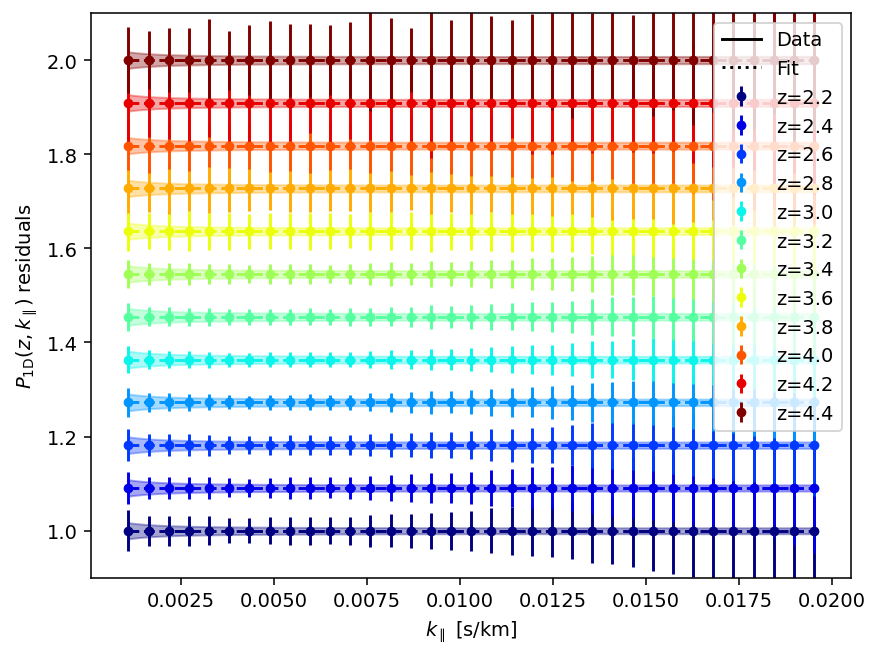

In [7]:
like.plot_p1d(residuals=True)

### Run iminuit minimizer

In [8]:
minimizer = iminuit_minimizer.IminuitMinimizer(like)

In [9]:
minimizer.minimize(compute_hesse=True)

will run migrad
W VariableMetricBuilder Matrix not pos.def, gdel = 5.64929e+187 > 0
W MnPosDef non-positive diagonal element in covariance matrix[ 12 ] = -5.55112e-17
W MnPosDef Added to diagonal of Error matrix a value 0.500001
W VariableMetricBuilder gdel = -5.08844e+203
W VariableMetricBuilder No improvement in line search
W VariableMetricBuilder Iterations finish without convergence; Edm 9.05286e+203 Requested 0.0001
W MnPosDef Matrix forced pos-def by adding to diagonal 0.0183226
W DavidonErrorUpdator delgam < 0 : first derivatives increasing along search line
W VariableMetricBuilder Matrix not pos.def, gdel = 2.40768 > 0
W MnPosDef non-positive diagonal element in covariance matrix[ 0 ] = -0.00154548
W MnPosDef non-positive diagonal element in covariance matrix[ 4 ] = -0.0021953
W MnPosDef non-positive diagonal element in covariance matrix[ 5 ] = -0.00543125
W MnPosDef non-positive diagonal element in covariance matrix[ 11 ] = -0.00426435
W MnPosDef Added to diagonal of Error mat

best-fit values = [0.52249156 0.4172717  0.53427469 0.05442313 0.52360655 0.6203055
 0.53324981 0.60437447 0.62321125 0.51682734 0.80824254 0.45037082
 0.99911033 0.62615187]


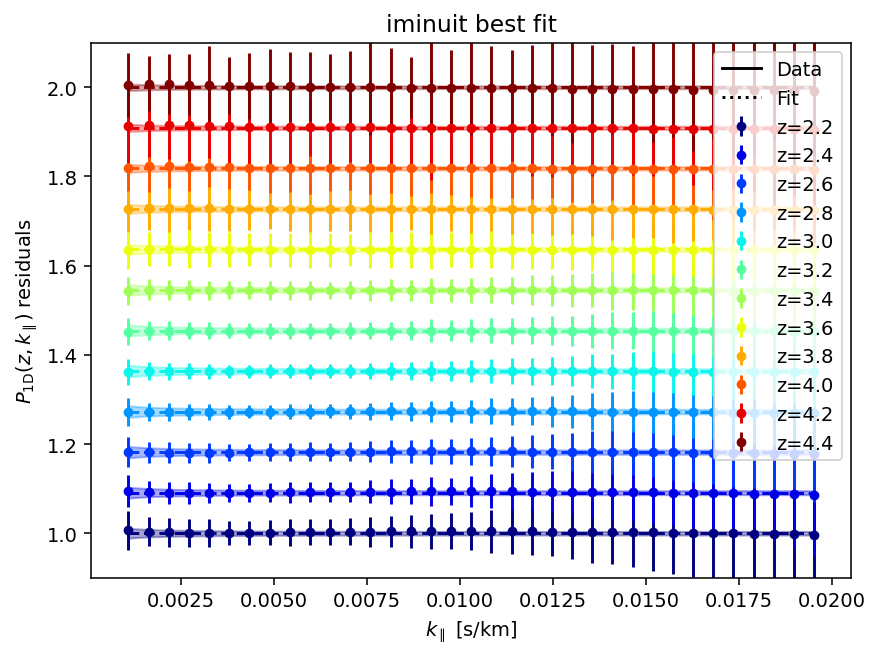

In [10]:
plt.figure()
minimizer.plot_best_fit()

compute true values for As ns


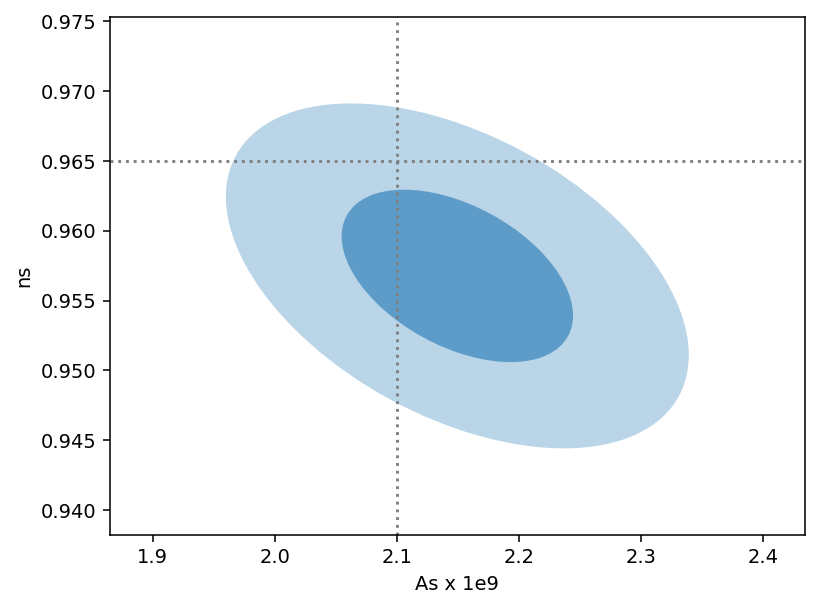

In [11]:
minimizer.plot_ellipses('As','ns')